<a href="https://colab.research.google.com/github/rahiakela/probabilistic-programming-practice/blob/main/tensorflow_probability_labs/guide/01_tour_of_tensorflow_probability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## A Tour of TensorFlow Probability

In this Colab, we explore some of the fundamental features of TensorFlow Probability. 

### Dependencies & Prerequisites


In [ ]:
#@title Import { display-mode: "form" }


from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'

%matplotlib inline

tfd = tfp.distributions
tfb = tfp.bijectors

In [ ]:
#@title Utils { display-mode: "form" }
def print_subclasses_from_module(module, base_class, maxwidth=80):
  import functools, inspect, sys
  subclasses = [name for name, obj in inspect.getmembers(module)
                if inspect.isclass(obj) and issubclass(obj, base_class)]
  def red(acc, x):
    if not acc or len(acc[-1]) + len(x) + 2 > maxwidth:
      acc.append(x)
    else:
      acc[-1] += ", " + x
    return acc
  print('\n'.join(functools.reduce(red, subclasses, [])))

## Outline

* TensorFlow
* TensorFlow Probability
  * Distributions
  * Bijectors
  * MCMC
  * ...and more!

## Preamble: TensorFlow

TensorFlow is a scientific computing library.

---

It supports
  * lots of mathematical operations
  * efficient vectorized computation
  * easy hardware acceleration
  * automatic differentiation

### Vectorization

 * Vectorization makes things fast!
  * It also means we think a lot about shapes

In [ ]:
mats = tf.random.uniform(shape=[1000, 10, 10])
vecs = tf.random.uniform(shape=[1000, 10, 1])

def for_loop_solve():
  return np.array(
    [tf.linalg.solve(mats[i, ...], vecs[i, ...]) for i in range(1000)])

def vectorized_solve():
  return tf.linalg.solve(mats, vecs)

# Vectorization for the win!
%timeit for_loop_solve()
%timeit vectorized_solve()

1 loop, best of 5: 226 ms per loop
1000 loops, best of 5: 1.24 ms per loop


In [ ]:
mats.shape

TensorShape([1000, 10, 10])

### Hardware Acceleration

In [ ]:
# Code can run seamlessly on a GPU, just change Colab runtime type
# in the 'Runtime' menu.
if tf.test.gpu_device_name() == '/device:GPU:0':
  print("Using a GPU")
else:
  print("Using a CPU")

Using a CPU


### Automatic Differentiation

In [ ]:
a = tf.constant(np.pi)
b = tf.constant(np.e)
with tf.GradientTape() as tape:
  tape.watch([a, b])
  c = .5 * (a**2 + b**2)
grads = tape.gradient(c, [a, b])
print(grads[0])
print(grads[1])

tf.Tensor(3.1415927, shape=(), dtype=float32)
tf.Tensor(2.7182817, shape=(), dtype=float32)


## TensorFlow Probability

*TensorFlow Probability is a library for probabilistic reasoning and statistical analysis in TensorFlow.*

We support *modeling*, *inference*, and *criticism* through composition of low-level modular components.

### Low-level building blocks
  * Distributions
  * Bijectors

### High(er)-level constructs
  * Markov chain Monte Carlo
  * Probabilistic Layers
  * Structural Time Series
  * Generalized Linear Models
  * Optimizers

## Distributions

A `tfp.distributions.Distribution` is a class with two core methods: `sample` and `log_prob`.

TFP has a lot of distributions!

In [ ]:
print_subclasses_from_module(tfp.distributions, tfp.distributions.Distribution)

Autoregressive, BatchReshape, Bates, Bernoulli, Beta, BetaBinomial, Binomial
Blockwise, Categorical, Cauchy, Chi, Chi2, CholeskyLKJ, ContinuousBernoulli
Deterministic, Dirichlet, DirichletMultinomial, Distribution, DoublesidedMaxwell
Empirical, ExpGamma, ExpInverseGamma, ExpRelaxedOneHotCategorical, Exponential
ExponentiallyModifiedGaussian, FiniteDiscrete, Gamma, GammaGamma
GaussianProcess, GaussianProcessRegressionModel, GeneralizedExtremeValue
GeneralizedNormal, GeneralizedPareto, Geometric, Gumbel, HalfCauchy, HalfNormal
HalfStudentT, HiddenMarkovModel, Horseshoe, Independent, InverseGamma
InverseGaussian, JohnsonSU, JointDistribution, JointDistributionCoroutine
JointDistributionCoroutineAutoBatched, JointDistributionNamed
JointDistributionNamedAutoBatched, JointDistributionSequential
JointDistributionSequentialAutoBatched, Kumaraswamy, LKJ, Laplace
LinearGaussianStateSpaceModel, LogLogistic, LogNormal, Logistic, LogitNormal
Mixture, MixtureSameFamily, Moyal, Multinomial, Multivari

### A simple scalar-variate `Distribution`

In [ ]:
# A standard normal
normal = tfd.Normal(loc=0., scale=1.)
print(normal)

tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


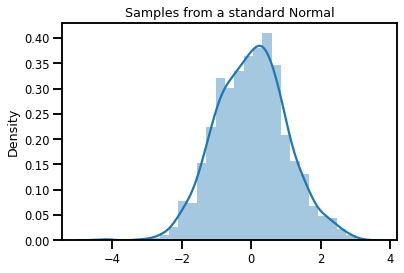

In [ ]:
# Plot 1000 samples from a standard normal
samples = normal.sample(1000)
sns.distplot(samples)
plt.title("Samples from a standard Normal")
plt.show()

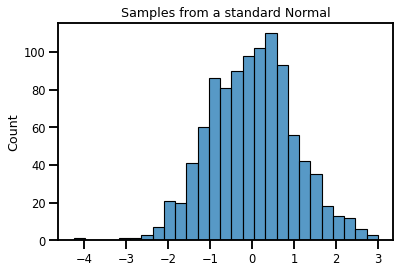

In [ ]:
sns.histplot(samples)
plt.title("Samples from a standard Normal")
plt.show()

tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


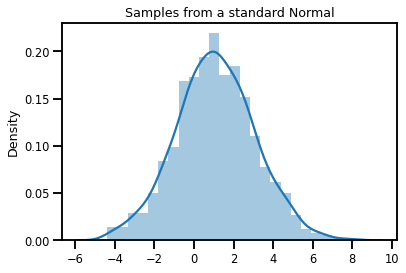

In [ ]:
# A standard normal
normal2 = tfd.Normal(loc=1., scale=2.)
print(normal2)

# Plot 1000 samples from a standard normal
samples2 = normal2.sample(1000)
sns.distplot(samples2)
plt.title("Samples from a standard Normal")
plt.show()

In [ ]:
# Compute the log_prob of a point in the event space of `normal`
normal.log_prob(0.)

<tf.Tensor: shape=(), dtype=float32, numpy=-1.7370857>

In [ ]:
# Compute the log_prob of a few points
normal.log_prob([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-2.1120858, -1.7370857, -1.6120857], dtype=float32)>

### Distributions and Shapes

Numpy `ndarrays` and TensorFlow `Tensors` have *shapes*.

TensorFlow Probability `Distributions` have *shape semantics* -- we partition shapes into semantically distinct pieces, even though the same chunk of memory (`Tensor`/`ndarray`) is used for the whole everything.

  * **Batch shape** denotes a *collection* of `Distribution`s with distinct parameters
  * **Event shape** denotes the shape of *samples* from the `Distribution`.

We always put batch shapes on the "left" and event shapes on the "right".

### A *batch* of scalar-variate `Distributions`


Batches are like "vectorized" distributions: independent instances whose computations happen in parallel.

In [ ]:
# Create a batch of 3 normals, and plot 1000 samples from each
normals = tfd.Normal([-2.5, 0., 2.5], 1.)  # The scale parameter broadacasts!
print("Batch shape:", normals.batch_shape)
print("Event shape:", normals.event_shape)

Batch shape: (3,)
Event shape: ()


In [ ]:
# Samples' shapes go on the left!
samples = normals.sample(1000)
print("Shape of samples:", samples.shape)

Shape of samples: (1000, 3)


In [ ]:
# Sample shapes can themselves be more complicated
print("Shape of samples:", normals.sample([10, 10, 10]).shape)

Shape of samples: (10, 10, 10, 3)


In [ ]:
# A batch of normals gives a batch of log_probs.
print(normals.log_prob([-2.5, 0., 2.5]))

tf.Tensor([-0.9189385 -0.9189385 -0.9189385], shape=(3,), dtype=float32)


In [ ]:
# The computation broadcasts, so a batch of normals applied to a scalar
# also gives a batch of log_probs.
print(normals.log_prob(0.))

tf.Tensor([-4.0439386 -0.9189385 -4.0439386], shape=(3,), dtype=float32)


In [ ]:
# Normal numpy-like broadcasting rules apply!
xs = np.linspace(-6, 6, 200)
try:
  normals.log_prob(xs)
except Exception as e:
  print("TFP error:", e.message)

TFP error: Incompatible shapes: [200] vs. [3] [Op:SquaredDifference]


In [ ]:
# That fails for the same reason this does:
try:
  np.zeros(200) + np.zeros(3)
except Exception as e:
  print("Numpy error:", e)

Numpy error: operands could not be broadcast together with shapes (200,) (3,) 


In [ ]:
# But this would work:
a = np.zeros([200, 1]) + np.zeros(3)
print("Broadcast shape:", a.shape)

Broadcast shape: (200, 3)


In [ ]:
# And so will this!
xs = np.linspace(-6, 6, 200)[..., np.newaxis]
# => shape = [200, 1]

lps = normals.log_prob(xs)
print("Broadcast log_prob shape:", lps.shape)

Broadcast log_prob shape: (200, 3)


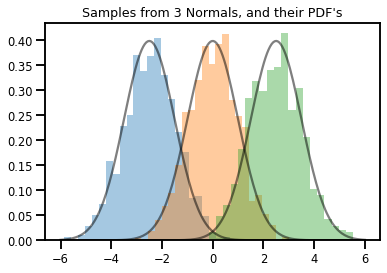

In [ ]:
# Summarizing visually
for i in range(3):
  sns.distplot(samples[:, i], kde=False, norm_hist=True)
plt.plot(np.tile(xs, 3), normals.prob(xs), c='k', alpha=.5)
plt.title("Samples from 3 Normals, and their PDF's")
plt.show()

### A vector-variate `Distribution`

In [ ]:
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag = [1., 1.])
print("Batch shape:", mvn.batch_shape)
print("Event shape:", mvn.event_shape)

Batch shape: ()
Event shape: (2,)


In [ ]:
samples = mvn.sample(1000)
print("Samples shape:", samples.shape)

Samples shape: (1000, 2)


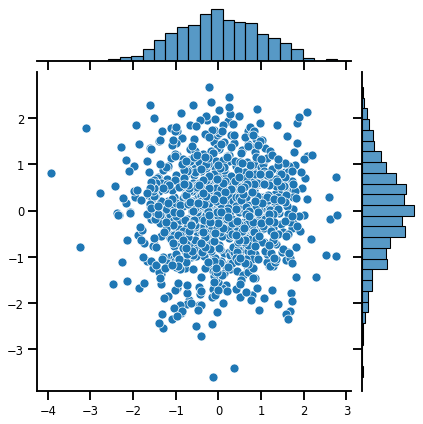

In [ ]:
g = sns.jointplot(samples[:, 0], samples[:, 1], kind='scatter')
plt.show()

### A matrix-variate `Distribution`

In [ ]:
lkj = tfd.LKJ(dimension=10, concentration=[1.5, 3.0])
print("Batch shape: ", lkj.batch_shape)
print("Event shape: ", lkj.event_shape)

Batch shape:  (2,)
Event shape:  (10, 10)


In [ ]:
samples = lkj.sample()
print("Samples shape: ", samples.shape)

Samples shape:  (2, 10, 10)


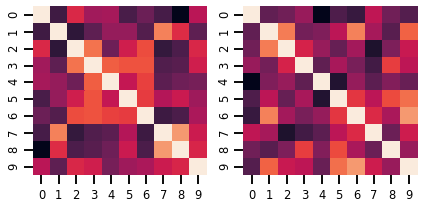

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
sns.heatmap(samples[0, ...], ax=axes[0], cbar=False)
sns.heatmap(samples[1, ...], ax=axes[1], cbar=False)
fig.tight_layout()
plt.show()

### Gaussian Processes

In [ ]:
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()
xs = np.linspace(-5., 5., 200).reshape([-1, 1])
gp = tfd.GaussianProcess(kernel, index_points=xs)
print("Batch shape:", gp.batch_shape)
print("Event shape:", gp.event_shape)

Batch shape: ()
Event shape: (200,)


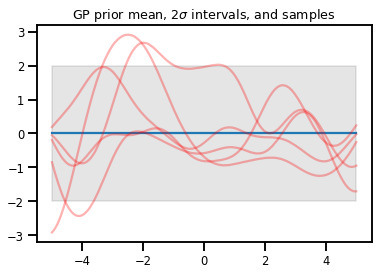

In [ ]:
upper, lower = gp.mean() + [2 * gp.stddev(), -2 * gp.stddev()]
plt.plot(xs, gp.mean())
plt.fill_between(xs[..., 0], upper, lower, color='k', alpha=.1)
for _ in range(5):
  plt.plot(xs, gp.sample(), c='r', alpha=.3)
plt.title(r"GP prior mean, $2\sigma$ intervals, and samples")
plt.show()

#    *** Bonus question ***
# Why do so many of these functions lie outside the 95% intervals?

### GP Regression

In [ ]:
# Suppose we have some observed data
obs_x = [[-3.], [0.], [2.]]  # Shape 3x1 (3 1-D vectors)
obs_y = [3., -2., 2.]        # Shape 3   (3 scalars)

gprm = tfd.GaussianProcessRegressionModel(kernel, xs, obs_x, obs_y)

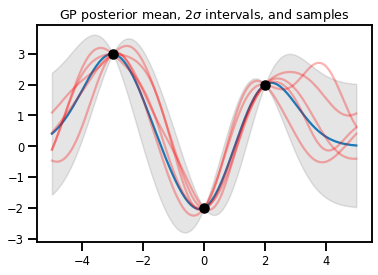

In [ ]:
upper, lower = gprm.mean() + [2 * gprm.stddev(), -2 * gprm.stddev()]
plt.plot(xs, gprm.mean())
plt.fill_between(xs[..., 0], upper, lower, color='k', alpha=.1)
for _ in range(5):
  plt.plot(xs, gprm.sample(), c='r', alpha=.3)
plt.scatter(obs_x, obs_y, c='k', zorder=3)
plt.title(r"GP posterior mean, $2\sigma$ intervals, and samples")
plt.show()

## Bijectors

Bijectors represent (mostly) invertible, smooth functions. They can be used to transform distributions, preserving the ability to take samples and compute log_probs. They can be in the `tfp.bijectors` module.

Each bijector implements at least 3 methods: 
  * `forward`,
  * `inverse`, and
  * (at least) one of `forward_log_det_jacobian` and `inverse_log_det_jacobian`.

With these ingredients, we can transform a distribution and still get samples and log probs from the result!

### In Math, somewhat sloppily

* $X$ is a random variable with pdf $p(x)$
* $g$ is a smooth, invertible function on the space of $X$'s
* $Y = g(X)$ is a new, transformed random variable
* $p(Y=y) = p(X=g^{-1}(y)) \cdot |\nabla g^{-1}(y)|$

### Caching
Bijectors also cache the forward and inverse computations, and log-det-Jacobians, which allows us to save
repeating potentially very expensive operations!

In [ ]:
print_subclasses_from_module(tfp.bijectors, tfp.bijectors.Bijector)

AbsoluteValue, Affine, AffineLinearOperator, AffineScalar, Ascending
AutoCompositeTensorBijector, BatchNormalization, Bijector, Blockwise, Chain
CholeskyOuterProduct, CholeskyToInvCholesky, Composition, CorrelationCholesky
Cumsum, DiscreteCosineTransform, Exp, Expm1, FFJORD, FillScaleTriL
FillTriangular, FrechetCDF, GeneralizedExtremeValueCDF, GeneralizedPareto, Glow
GompertzCDF, GumbelCDF, Identity, Inline, Invert, IteratedSigmoidCentered
JointMap, KumaraswamyCDF, LambertWTail, Log, Log1p, MaskedAutoregressiveFlow
MatrixInverseTriL, MatvecLU, MoyalCDF, NormalCDF, Ordered, Pad, Permute, Power
PowerTransform, RationalQuadraticSpline, RayleighCDF, RealNVP, Reciprocal
Reshape, Restructure, Scale, ScaleMatvecDiag, ScaleMatvecLU
ScaleMatvecLinearOperator, ScaleMatvecLinearOperatorBlock, ScaleMatvecTriL
Shift, ShiftedGompertzCDF, Sigmoid, Sinh, SinhArcsinh, SoftClip, Softfloor
SoftmaxCentered, Softplus, Softsign, Split, Square, Tanh, TransformDiagonal
Transpose, WeibullCDF


### A Simple `Bijector`

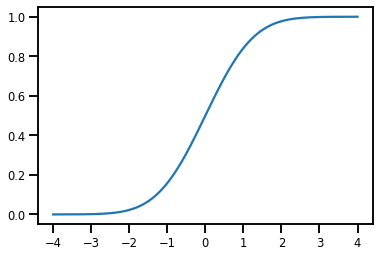

In [ ]:
normal_cdf = tfp.bijectors.NormalCDF()
xs = np.linspace(-4., 4., 200)
plt.plot(xs, normal_cdf.forward(xs))
plt.show()

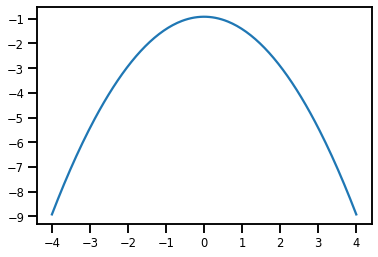

In [ ]:
plt.plot(xs, normal_cdf.forward_log_det_jacobian(xs, event_ndims=0))
plt.show()

### A `Bijector` transforming a `Distribution`

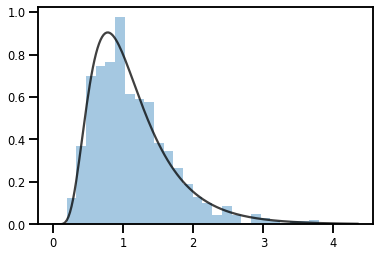

In [ ]:
exp_bijector = tfp.bijectors.Exp()
log_normal = exp_bijector(tfd.Normal(0., .5))

samples = log_normal.sample(1000)
xs = np.linspace(1e-10, np.max(samples), 200)
sns.distplot(samples, norm_hist=True, kde=False)
plt.plot(xs, log_normal.prob(xs), c='k', alpha=.75)
plt.show()

### Batching `Bijectors`

In [ ]:
# Create a batch of bijectors of shape [3,]
softplus = tfp.bijectors.Softplus(hinge_softness=[1., .5, .1])
print("Hinge softness shape:", softplus.hinge_softness.shape)

Hinge softness shape: (3,)


In [ ]:
# For broadcasting, we want this to be shape [200, 1]
xs = np.linspace(-4., 4., 200)[..., np.newaxis]
ys = softplus.forward(xs)
print("Forward shape:", ys.shape)

Forward shape: (200, 3)


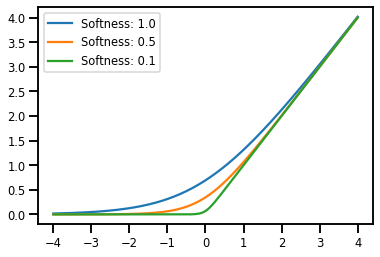

In [ ]:
# Visualization
lines = plt.plot(np.tile(xs, 3), ys)
for line, hs in zip(lines, softplus.hinge_softness):
  line.set_label("Softness: %1.1f" % hs)
plt.legend()
plt.show()

### Caching

In [ ]:
# This bijector represents a matrix outer product on the forward pass,
# and a cholesky decomposition on the inverse pass. The latter costs O(N^3)!
bij = tfb.CholeskyOuterProduct()

size = 2500
# Make a big, lower-triangular matrix
big_lower_triangular = tf.eye(size)
# Squaring it gives us a positive-definite matrix
big_positive_definite = bij.forward(big_lower_triangular)

# Caching for the win!
%timeit bij.inverse(big_positive_definite)
%timeit tf.linalg.cholesky(big_positive_definite)

10000 loops, best of 5: 173 µs per loop
1 loop, best of 5: 247 ms per loop


## MCMC

TFP has built in support for some standard Markov chain Monte Carlo algorithms, including Hamiltonian Monte Carlo.

### Generate a data set

In [ ]:
# Generate some data
def f(x, w):
  # Pad x with 1's so we can add bias via matmul
  x = tf.pad(x, [[1, 0], [0, 0]], constant_values=1)
  linop = tf.linalg.LinearOperatorFullMatrix(w[..., np.newaxis])
  result = linop.matmul(x, adjoint=True)
  return result[..., 0, :]

num_features = 2
num_examples = 50
noise_scale = .5
true_w = np.array([-1., 2., 3.])

xs = np.random.uniform(-1., 1., [num_features, num_examples])
ys = f(xs, true_w) + np.random.normal(0., noise_scale, size=num_examples)

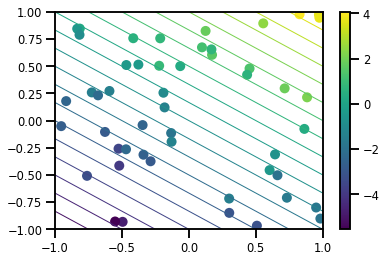

In [ ]:
# Visualize the data set
plt.scatter(*xs, c=ys, s=100, linewidths=0)

grid = np.meshgrid(*([np.linspace(-1, 1, 100)] * 2))
xs_grid = np.stack(grid, axis=0)
fs_grid = f(xs_grid.reshape([num_features, -1]), true_w)
fs_grid = np.reshape(fs_grid, [100, 100])
plt.colorbar()
plt.contour(xs_grid[0, ...], xs_grid[1, ...], fs_grid, 20, linewidths=1)
plt.show()

### Define our joint log-prob function

The unnormalized posterior is the result of closing over the data to form a
[partial application](https://en.wikipedia.org/wiki/Partial_application) of the joint log prob.

In [ ]:
# Define the joint_log_prob function, and our unnormalized posterior.
def joint_log_prob(w, x, y):
  # Our model in maths is
  #   w ~ MVN([0, 0, 0], diag([1, 1, 1]))
  #   y_i ~ Normal(w @ x_i, noise_scale),  i=1..N

  rv_w = tfd.MultivariateNormalDiag(
    loc=np.zeros(num_features + 1),
    scale_diag=np.ones(num_features + 1))

  rv_y = tfd.Normal(f(x, w), noise_scale)
  return (rv_w.log_prob(w) +
          tf.reduce_sum(rv_y.log_prob(y), axis=-1))

In [ ]:
# Create our unnormalized target density by currying x and y from the joint.
def unnormalized_posterior(w):
  return joint_log_prob(w, xs, ys)

### Build HMC TransitionKernel and call sample_chain

In [ ]:
# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unnormalized_posterior,
  step_size=np.float64(.1),
  num_leapfrog_steps=2)

In [ ]:
# We wrap sample_chain in tf.function, telling TF to precompile a reusable
# computation graph, which will dramatically improve performance.
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
  return tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_state,
    kernel=hmc_kernel,
    trace_fn=lambda current_state, kernel_results: kernel_results)

In [ ]:
initial_state = np.zeros(num_features + 1)
samples, kernel_results = run_chain(initial_state)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

Acceptance rate: 0.898


*That's not great! We'd like an acceptance rate closer to .65.*

(see ["Optimal Scaling for Various Metropolis-Hastings Algorithms"](https://projecteuclid.org/euclid.ss/1015346320), Roberts & Rosenthal, 2001)


### Adaptive step sizes

We can wrap our HMC TransitionKernel in a `SimpleStepSizeAdaptation` "meta-kernel", which will apply some (rather simple heuristic) logic to adapt the HMC step size during burnin. We allot 80% of burnin for adapting step size, and then let the remaining 20% go just to mixing.

In [ ]:
# Apply a simple step size adaptation during burnin
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
  adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
      hmc_kernel,
      num_adaptation_steps=int(.8 * num_burnin_steps),
      target_accept_prob=np.float64(.65))

  return tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_state,
    kernel=adaptive_kernel,
    trace_fn=lambda cs, kr: kr)

In [ ]:
samples, kernel_results = run_chain(initial_state=np.zeros(num_features+1))
print("Acceptance rate:", kernel_results.inner_results.is_accepted.numpy().mean())

Acceptance rate: 0.718


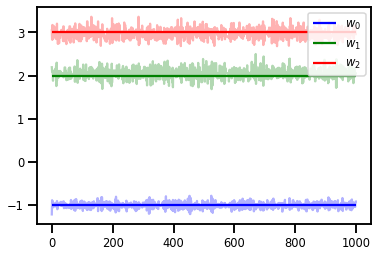

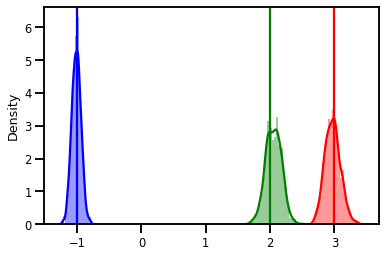

In [ ]:
# Trace plots
colors = ['b', 'g', 'r']
for i in range(3):
  plt.plot(samples[:, i], c=colors[i], alpha=.3)
  plt.hlines(true_w[i], 0, 1000, zorder=4, color=colors[i], label="$w_{}$".format(i))
plt.legend(loc='upper right')
plt.show()

# Histogram of samples
for i in range(3):
  sns.distplot(samples[:, i], color=colors[i])
ymax = plt.ylim()[1]
for i in range(3):
  plt.vlines(true_w[i], 0, ymax, color=colors[i])
plt.ylim(0, ymax)
plt.show()

### Diagnostics

Trace plots are nice, but diagnostics are nicer!

First we need to run multiple chains. This is as simple as giving a batch of
`initial_state` tensors.

In [ ]:
# Instead of a single set of initial w's, we create a batch of 8.
num_chains = 8
initial_state = np.zeros([num_chains, num_features + 1])

chains, kernel_results = run_chain(initial_state)

r_hat = tfp.mcmc.potential_scale_reduction(chains)
print("Acceptance rate:", kernel_results.inner_results.is_accepted.numpy().mean())
print("R-hat diagnostic (per latent variable):", r_hat.numpy())

Acceptance rate: 0.677875
R-hat diagnostic (per latent variable): [0.999348   1.00123739 1.00145696]


### Sampling the noise scale

In [ ]:
# Define the joint_log_prob function, and our unnormalized posterior.
def joint_log_prob(w, sigma, x, y):
  # Our model in maths is
  #   w ~ MVN([0, 0, 0], diag([1, 1, 1]))
  #   y_i ~ Normal(w @ x_i, noise_scale),  i=1..N

  rv_w = tfd.MultivariateNormalDiag(
    loc=np.zeros(num_features + 1),
    scale_diag=np.ones(num_features + 1))
  
  rv_sigma = tfd.LogNormal(np.float64(1.), np.float64(5.))

  rv_y = tfd.Normal(f(x, w), sigma[..., np.newaxis])
  return (rv_w.log_prob(w) +
          rv_sigma.log_prob(sigma) +
          tf.reduce_sum(rv_y.log_prob(y), axis=-1))

# Create our unnormalized target density by currying x and y from the joint.
def unnormalized_posterior(w, sigma):
  return joint_log_prob(w, sigma, xs, ys)


# Create an HMC TransitionKernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unnormalized_posterior,
  step_size=np.float64(.1),
  num_leapfrog_steps=4)



# Create a TransformedTransitionKernl
transformed_kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=hmc_kernel,
    bijector=[tfb.Identity(),    # w
              tfb.Invert(tfb.Softplus())])   # sigma


# Apply a simple step size adaptation during burnin
@tf.function
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
  adaptive_kernel = tfp.mcmc.SimpleStepSizeAdaptation(
      transformed_kernel,
      num_adaptation_steps=int(.8 * num_burnin_steps),
      target_accept_prob=np.float64(.75))

  return tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=initial_state,
    kernel=adaptive_kernel,
    seed=(0, 1),
    trace_fn=lambda cs, kr: kr)


# Instead of a single set of initial w's, we create a batch of 8.
num_chains = 8
initial_state = [np.zeros([num_chains, num_features + 1]),
                 .54 * np.ones([num_chains], dtype=np.float64)]

chains, kernel_results = run_chain(initial_state)

r_hat = tfp.mcmc.potential_scale_reduction(chains)
print("Acceptance rate:", kernel_results.inner_results.inner_results.is_accepted.numpy().mean())
print("R-hat diagnostic (per w variable):", r_hat[0].numpy())
print("R-hat diagnostic (sigma):", r_hat[1].numpy())


Acceptance rate: 0.77625
R-hat diagnostic (per w variable): [1.00146704 1.00053623 1.00298184]
R-hat diagnostic (sigma): 1.0060304991601037


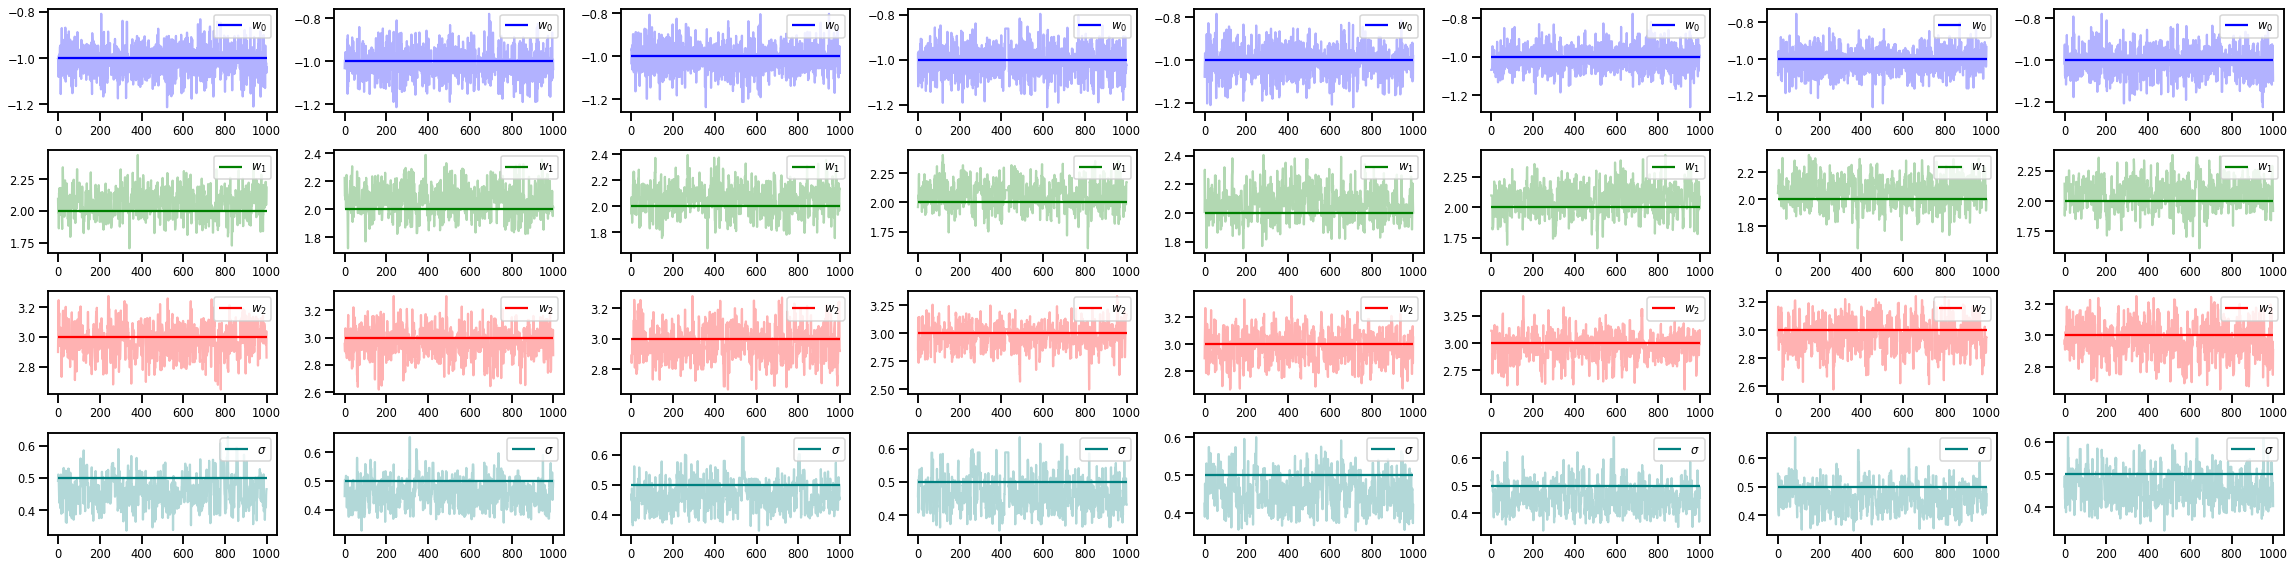

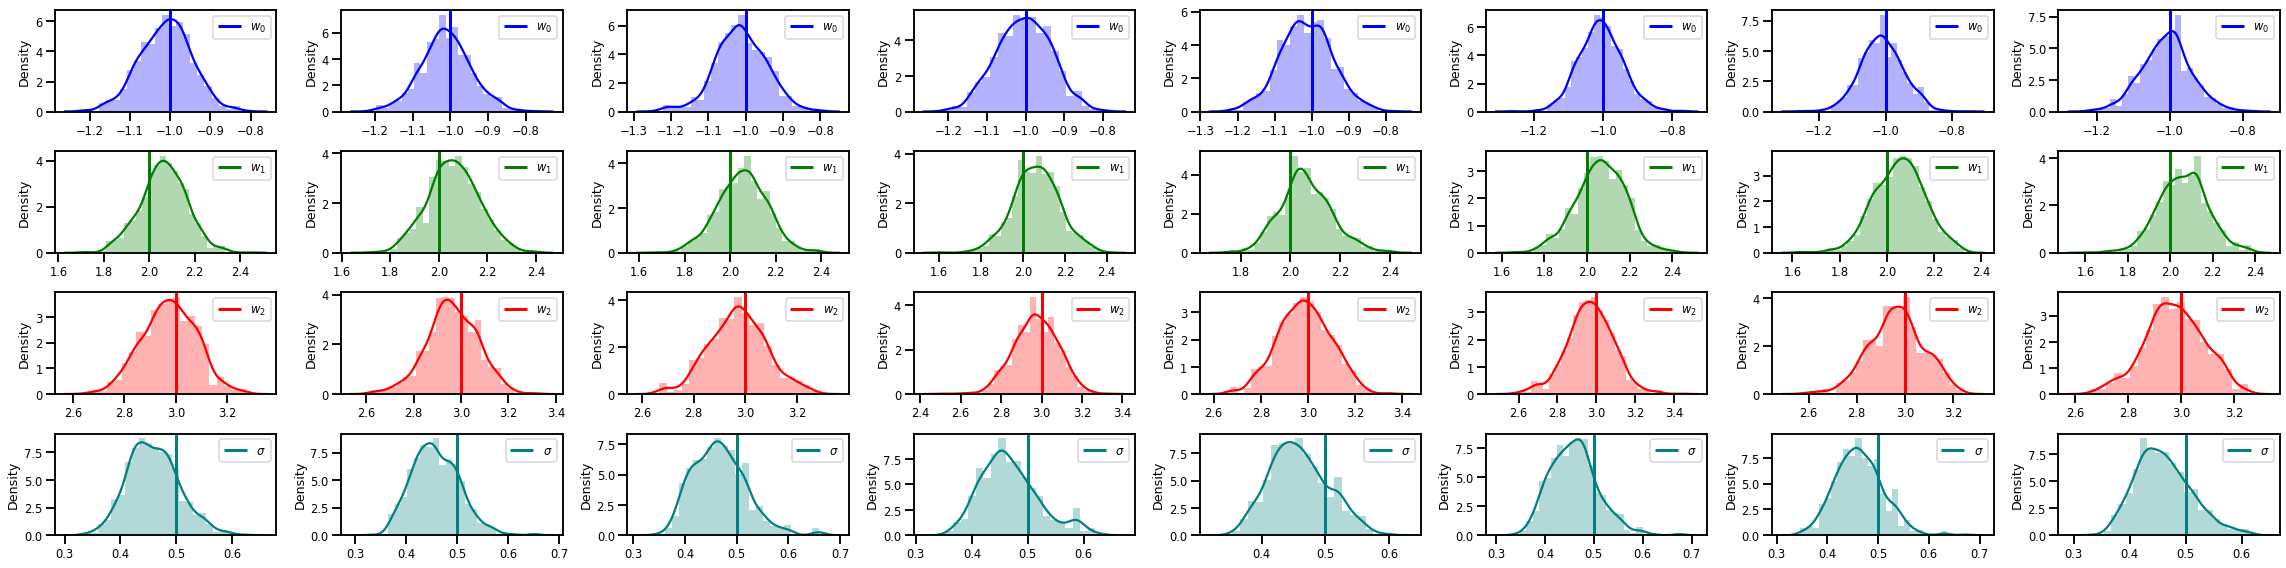

In [ ]:
w_chains, sigma_chains = chains

# Trace plots of w (one of 8 chains)
colors = ['b', 'g', 'r', 'teal']
fig, axes = plt.subplots(4, num_chains, figsize=(4 * num_chains, 8))
for j in range(num_chains):
  for i in range(3):
    ax = axes[i][j]
    ax.plot(w_chains[:, j, i], c=colors[i], alpha=.3)
    ax.hlines(true_w[i], 0, 1000, zorder=4, color=colors[i], label="$w_{}$".format(i))
    ax.legend(loc='upper right')
  ax = axes[3][j]
  ax.plot(sigma_chains[:, j], alpha=.3, c=colors[3])
  ax.hlines(noise_scale, 0, 1000, zorder=4, color=colors[3], label=r"$\sigma$".format(i))
  ax.legend(loc='upper right')
fig.tight_layout()
plt.show()

# Histogram of samples of w
fig, axes = plt.subplots(4, num_chains, figsize=(4 * num_chains, 8))
for j in range(num_chains):
  for i in range(3):
    ax = axes[i][j]
    sns.distplot(w_chains[:, j, i], color=colors[i], norm_hist=True, ax=ax, hist_kws={'alpha': .3})
  for i in range(3):
    ax = axes[i][j]
    ymax = ax.get_ylim()[1]
    ax.vlines(true_w[i], 0, ymax, color=colors[i], label="$w_{}$".format(i), linewidth=3)
    ax.set_ylim(0, ymax)
    ax.legend(loc='upper right')


  ax = axes[3][j]
  sns.distplot(sigma_chains[:, j], color=colors[3], norm_hist=True, ax=ax, hist_kws={'alpha': .3})
  ymax = ax.get_ylim()[1]
  ax.vlines(noise_scale, 0, ymax, color=colors[3], label=r"$\sigma$".format(i), linewidth=3)
  ax.set_ylim(0, ymax)
  ax.legend(loc='upper right')
fig.tight_layout()
plt.show()

## There's a lot more!

Check out these cool blog posts and examples:

* Structural Time Series support [blog](https://medium.com/tensorflow/structural-time-series-modeling-in-tensorflow-probability-344edac24083) [colab](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand.ipynb)
* Probabilistic Keras Layers (input: Tensor, output: Distribution!) [blog](https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf) [colab](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb)
  * Another Layers example: VAEs [blog](https://medium.com/tensorflow/variational-autoencoders-with-tensorflow-probability-layers-d06c658931b7) [colab](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_VAE.ipynb)
* Gaussian Process Regression [colab](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Regression_In_TFP.ipynb) and Latent Variable Modeling [colab](https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Latent_Variable_Model.ipynb)

More examples and notebooks on our GitHub [here](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/examples)!